In [2]:
import sys
import os
sys.path.append(os.path.abspath("../"))

import numpy as np
import pandas as pd
import ast
import utils
# Color clustering
from sklearn.cluster import KMeans
# Cluster analysis
from scipy.spatial import KDTree
from matplotlib import colors as mcolors
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
# Cluster plotting
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.patches as patches

In [3]:
df = pd.read_csv("omniart-paintings-filtered-clean-hsb.csv.gz")

In [4]:
df

,artwork_name,artist_full_name,creation_year,century,school,color_pallete,dominant_color,palette_count,decade,H,S,B
0,70 amx,xynphix,2007.0,21.0,modern,"['#e2f5e5', '#a5ab9e', '#65c7a3', '#243b39', '...",#a5ab9e,"[4009, 7637, 3303, 6147, 4742, 3908, 7216, 514...",2000,"[0.3596491228070177, 0.2435897435897434, 0.438...","[0.07755102040816333, 0.0760233918128654, 0.49...","[0.9607843137254902, 0.6705882352941176, 0.780..."
1,crucifixion (detail),andrea da firenze,1366.0,14.0,Italy,"['#a18b78', '#866b58', '#7c5340', '#5b4b3f', '...",#110d0d,"[6226, 6056, 4293, 6101, 5185, 5292, 6392, 384...",1360,"[0.07723577235772354, 0.06884057971014494, 0.0...","[0.2546583850931677, 0.3432835820895523, 0.483...","[0.6313725490196078, 0.5254901960784314, 0.486..."
2,faith,giuseppe angeli,1754.0,18.0,Italy,"['#000202', '#a3754c', '#935531', '#1d130c', '...",#000000,"[1007, 4537, 4708, 4466, 4432, 2946, 4776, 448...",1750,"[0.5, 0.07854406130268199, 0.06122448979591838...","[1.0, 0.5337423312883435, 0.6666666666666666, ...","[0.00784313725490196, 0.6392156862745098, 0.57..."
3,lamp post,williamsnape,2010.0,21.0,modern,"['#cdada2', '#987d71', '#503b33', '#311d1b', '...",#233b49,"[4225, 4308, 4914, 6274, 6911, 6261, 6753, 421...",2010,"[0.04263565891472874, 0.05128205128205129, 0.0...","[0.20975609756097569, 0.2565789473684211, 0.36...","[0.803921568627451, 0.596078431372549, 0.31372..."
4,the one that got away,katiehofgard,2009.0,21.0,modern,"['#ffffff', '#fdfdfd', '#fcfffe', '#9d7957', '...",#ffffff,"[43399, 1136, 407, 2637, 2812, 679, 3585, 2514...",2000,"[0.0, 0.0, 0.4444444444444444, 0.0809523809523...","[0.0, 0.0, 0.0117647058823529, 0.4458598726114...","[1.0, 0.9921568627450981, 1.0, 0.6156862745098..."
...,...,...,...,...,...,...,...,...,...,...,...,...
264213,truth,circlekeeper,2008.0,21.0,modern,"['#a86f61', '#a09d79', '#372b2e', '#252125', '...",#252125,"[1312, 5526, 9605, 9971, 4030, 5524, 5562, 286...",2000,"[0.032863849765258225, 0.15384615384615388, 0....","[0.4226190476190476, 0.24375000000000002, 0.21...","[0.6588235294117647, 0.6274509803921569, 0.215..."
264214,yavanna queen of the earth giver of fruits-tif...,tiffany-illustration,2017.0,21.0,modern,"['#ffffff', '#feffff', '#eef1df', '#c0af95', '...",#ffffff,"[15056, 255, 5087, 6846, 9838, 1577, 4027, 476...",2010,"[0.0, 0.5, 0.19444444444444434, 0.100775193798...","[0.0, 0.0039215686274509665, 0.074688796680497...","[1.0, 1.0, 0.9450980392156862, 0.7529411764705..."
264215,unknown,kano furunobu,1700.0,18.0,Japan,"['#b6ad97', '#af9974', '#a78d66', '#a19371', '...",#7e4e48,"[3431, 5740, 4247, 4971, 6362, 6885, 5328, 445...",1700,"[0.11827956989247314, 0.10451977401129942, 0.1...","[0.17032967032967034, 0.33714285714285713, 0.3...","[0.7137254901960784, 0.6862745098039216, 0.654..."
264216,unknown,wang yuanqi,1715.0,18.0,China,"['#f8f3ed', '#f4ede6', '#f1e3d0', '#edd9bb', '...",#e7d2b5,"[6512, 6102, 860, 6846, 4826, 5036, 5117, 3297...",1710,"[0.09090909090909068, 0.08333333333333333, 0.0...","[0.04435483870967738, 0.0573770491803279, 0.13...","[0.9725490196078431, 0.9568627450980393, 0.945..."


**1. Features**

In [5]:
color_dict = {}

for _, row in df.iterrows():
    hex_list = row["color_pallete"]
    h_list = row["H"]
    s_list = row["S"]
    b_list = row["B"]
    count_list = row["palette_count"]

    if isinstance(hex_list, str): hex_list = ast.literal_eval(hex_list)
    if isinstance(h_list, str): h_list = ast.literal_eval(h_list)
    if isinstance(s_list, str): s_list = ast.literal_eval(s_list)
    if isinstance(b_list, str): b_list = ast.literal_eval(b_list)
    if isinstance(count_list, str):count_list = ast.literal_eval(count_list)

    for hex_code, h, s, b, count in zip(hex_list, h_list, s_list, b_list, count_list):
        if hex_code not in color_dict:color_dict[hex_code] = [h, s, b, count]
        else: color_dict[hex_code][3] += count  # increment only the count

# Output list: (H, S, B, total_occurrence)
all_colors = [(h, s, b, count) for h, s, b, count in color_dict.values()]


In [6]:
unique_colors = np.array(all_colors)

In [7]:
len(unique_colors)

1197223

In [8]:
H = unique_colors[:, 0]
S = unique_colors[:, 1]
B = unique_colors[:, 2]
weights = unique_colors[:, 3]

In [9]:
features = np.column_stack((
    utils.hue_to_sin(H),    # Hue sin (hue is a circle)
    utils.hue_to_cos(H),    # Hue cos (hue is a circle)
    S, 
    B))

In [10]:
def plot_hues(H_sin, H_cos, weights=None, save_path=None):
    hues_rad = np.arctan2(H_sin, H_cos)
    hues_rad = np.mod(hues_rad, 2 * np.pi)
    hues_rad_plot = hues_rad  # already in radians for polar plot

    angles = np.linspace(0, 2 * np.pi, 360)

    kde = gaussian_kde(hues_rad_plot, bw_method=0.1, weights=weights)
    density = kde(angles)
    density_norm = density / density.max()

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)

    width = 2 * np.pi / len(angles)

    for angle, d in zip(angles, density_norm):
        hue_deg = np.rad2deg(angle) % 360
        color = mcolors.hsv_to_rgb([hue_deg / 360, 1, 1])
        ax.bar(angle, d, width=width, bottom=0, color=color, edgecolor=None, linewidth=0)

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_yticks([])
    ax.set_ylim(0, 1.1)
    ax.set_xticks(np.deg2rad(np.arange(0, 360, 10)))
    ax.set_xticklabels([str(x) for x in range(0, 360, 10)])

    plt.title('Hue degrees KDE Density')

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()

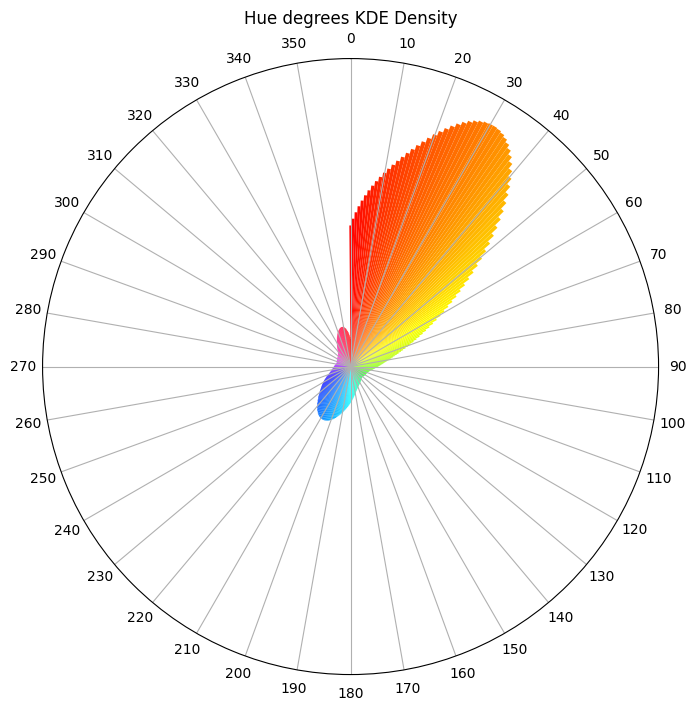

In [11]:
plot_hues(features[:, 0], features[:, 1], weights=weights)

In [12]:
def plot_saturation(S, weights=None, save_path=None):
    plt.figure(figsize=(8, 5))
    sns.kdeplot(x=S, bw_adjust=0.2, fill=True, color='skyblue', weights=weights)
    
    plt.title('Kernel Density Estimation of Saturation')
    
    plt.xlabel('Saturation')
    plt.ylabel('Density')
    plt.xticks([i/10 for i in range(11)])
    plt.grid(True)
    
    plt.axvline(x=0.15, color='gray', linestyle='--', label='Gray threshold')
    plt.axvline(x=0.4, color='steelblue', linestyle='--', label='Muted color threshold')
    
    plt.legend()
    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()

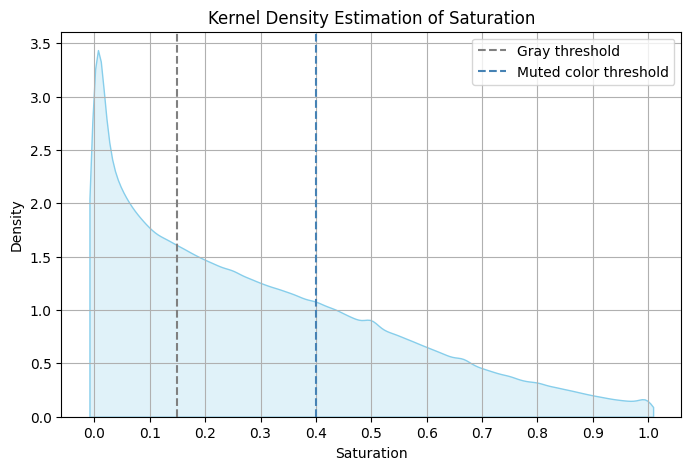

In [13]:
plot_saturation(features[:, 2], weights=weights)

In [14]:
def plot_brightness(B, weights=None, save_path=None):
    plt.figure(figsize=(8, 5))
    sns.kdeplot(x=B, bw_adjust=0.2, fill=True, color='skyblue', weights=weights)
    
    plt.title('Kernel Density Estimation of Brightness')
   
    plt.xlabel('Brightness')
    plt.ylabel('Density')
    plt.xticks([i/10 for i in range(11)])
    plt.grid(True)
    plt.axvline(x=0.1, color='black', linestyle='--', label='Black threshold')
    plt.axvline(x=0.9, color='white', linestyle='--', label='White threshold')
    
    plt.legend()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()

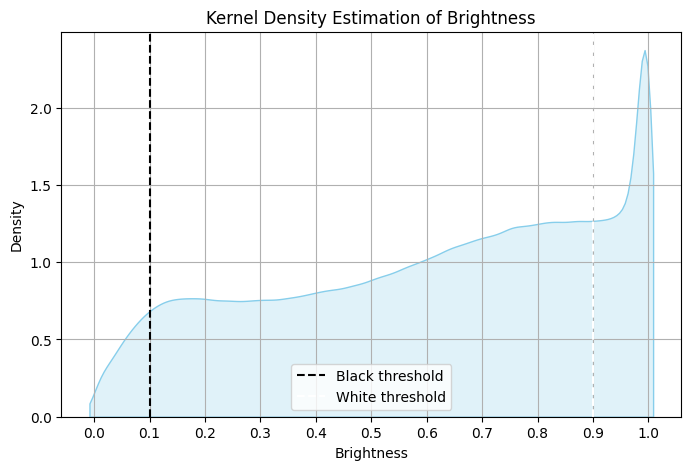

In [15]:
plot_brightness(features[:, 3], weights=weights)

**2. Clustering**

K = 1000: https://journals.sagepub.com/doi/10.1177/2041669520958431

In [16]:
K = 1000

In [17]:
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)

In [18]:
kmeans.fit(features, sample_weight=weights)

KMeans(n_clusters=1000, n_init=10, random_state=42)

In [19]:
centroids_df = pd.DataFrame(kmeans.cluster_centers_, columns=["H_sin", "H_cos", "S", "B"])

**3. Centroids information expansion**

In [20]:
centroids_df["H"] = centroids_df.apply(lambda row: utils.sin_cos_to_hue(row["H_sin"], row["H_cos"]), axis=1)

In [21]:
centroids_df["RGB"] = centroids_df.apply(lambda row: utils.hsb_to_rgb(row["H"], row["S"], row["B"]), axis=1)

In [22]:
centroids_df["HEX"] = centroids_df["RGB"].apply(lambda rgb: '#{:02x}{:02x}{:02x}'.format(*rgb))

In [23]:
# Build KDTree of XKCD colors
xkcd_dict = mcolors.XKCD_COLORS  # names like 'xkcd:vomit yellow'
xkcd_rgb = {
    name[5:]: tuple(int(v * 255) for v in mcolors.to_rgb(hex))  # strip 'xkcd:' and convert
    for name, hex in xkcd_dict.items()
}
xkcd_names = list(xkcd_rgb.keys())
xkcd_rgb_values = list(xkcd_rgb.values())
xkcd_tree = KDTree(xkcd_rgb_values)

In [24]:
# Match each RGB to closest XKCD name
def closest_xkcd(rgb_tuple):
    _, idx = xkcd_tree.query(rgb_tuple)
    return xkcd_names[idx]

In [25]:
centroids_df["name"] = centroids_df["RGB"].apply(closest_xkcd)

In [26]:
centroids_df["name"] = centroids_df["name"].str.replace(' ', '-', regex=False)

In [27]:
centroids_df

,H_sin,H_cos,S,B,H,RGB,HEX,name
0,4.443217e-01,0.895424,0.491299,0.679023,2.639125e+01,"(173, 125, 88)",#ad7d58,light-brown
1,-6.554393e-01,-0.753896,0.202037,0.747733,2.210038e+02,"(152, 164, 190)",#98a4be,bluey-grey
2,9.990871e-01,-0.008094,0.092816,0.276753,9.046415e+01,"(67, 70, 64)",#434640,charcoal-grey
3,2.775558e-17,1.000000,0.005139,0.884822,1.590277e-15,"(225, 224, 224)",#e1e0e0,light-grey
4,-9.979959e-01,0.003715,0.266481,0.491178,2.702133e+02,"(108, 91, 125)",#6c5b7d,purplish-grey
...,...,...,...,...,...,...,...,...
995,-6.653863e-01,-0.745473,0.172322,0.113356,2.217511e+02,"(23, 25, 28)",#17191c,dark
996,-9.342947e-02,0.994845,0.095521,0.927913,3.546349e+02,"(236, 214, 216)",#ecd6d8,pale-pink
997,1.110223e-16,-1.000000,0.065287,0.119456,1.800000e+02,"(28, 30, 30)",#1c1e1e,dark
998,9.973258e-01,-0.027237,0.642340,0.446398,9.156437e+01,"(75, 113, 40)",#4b7128,camo-green


In [28]:
centroids_df.to_csv("color-centroids.csv", index=False)

**3. Clustering metrics**

In [29]:
cluster_labels = kmeans.labels_

In [30]:
silhouette = silhouette_score(features, cluster_labels)
print("--- Clustering Evaluation Metrics ---")
print(f"Silhouette Score: {silhouette:.3f}")
print("  - Higher is better. Measures how similar an artwork is to its own cluster compared to others. Ranges from -1 to 1.")

--- Clustering Evaluation Metrics ---
Silhouette Score: 0.212
  - Higher is better. Measures how similar an artwork is to its own cluster compared to others. Ranges from -1 to 1.


In [31]:
calinski = calinski_harabasz_score(features, cluster_labels)
print(f"Calinski-Harabasz Score: {calinski:.3f}")
print("  - Higher is better. Measures the ratio of between-cluster dispersion to within-cluster dispersion.")

Calinski-Harabasz Score: 189733.403
  - Higher is better. Measures the ratio of between-cluster dispersion to within-cluster dispersion.


In [33]:
davies = davies_bouldin_score(features, cluster_labels)
print(f"Davies-Bouldin Index: {davies:.3f}")
print("  - Lower is better. Measures the average 'similarity' between clusters, where similarity is a measure of distance between clusters and the size of the clusters themselves.")

Davies-Bouldin Index: 0.977
  - Lower is better. Measures the average 'similarity' between clusters, where similarity is a measure of distance between clusters and the size of the clusters themselves.


In [ ]:
def plot_clusters_color_grid(df, save_path=None):
    # Sort by hue (H column)
    df = df.sort_values('H')

    # Create a grid layout - adjust these numbers based on your preference
    rows = 40
    cols = 25
    total_colors = rows * cols

    # Make sure we don't exceed the number of colors we have
    df = df.iloc[:total_colors]

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(20, 30))
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_aspect('equal')
    ax.axis('off')  # Turn off axes

    # Plot each color as a square in the grid
    for idx, (_, row) in enumerate(df.iterrows()):
        x = idx % cols
        y = rows - 1 - (idx // cols)  # Start from top
        
        # Create a rectangle with the color
        rect = patches.Rectangle((x, y), 1, 1, linewidth=0, 
                                facecolor=mcolors.to_rgb(row['HEX']))
        ax.add_patch(rect)

    plt.title('Clusters color Grid ordered by hue', fontsize=16, pad=20)
    
    plt.tight_layout()
    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()

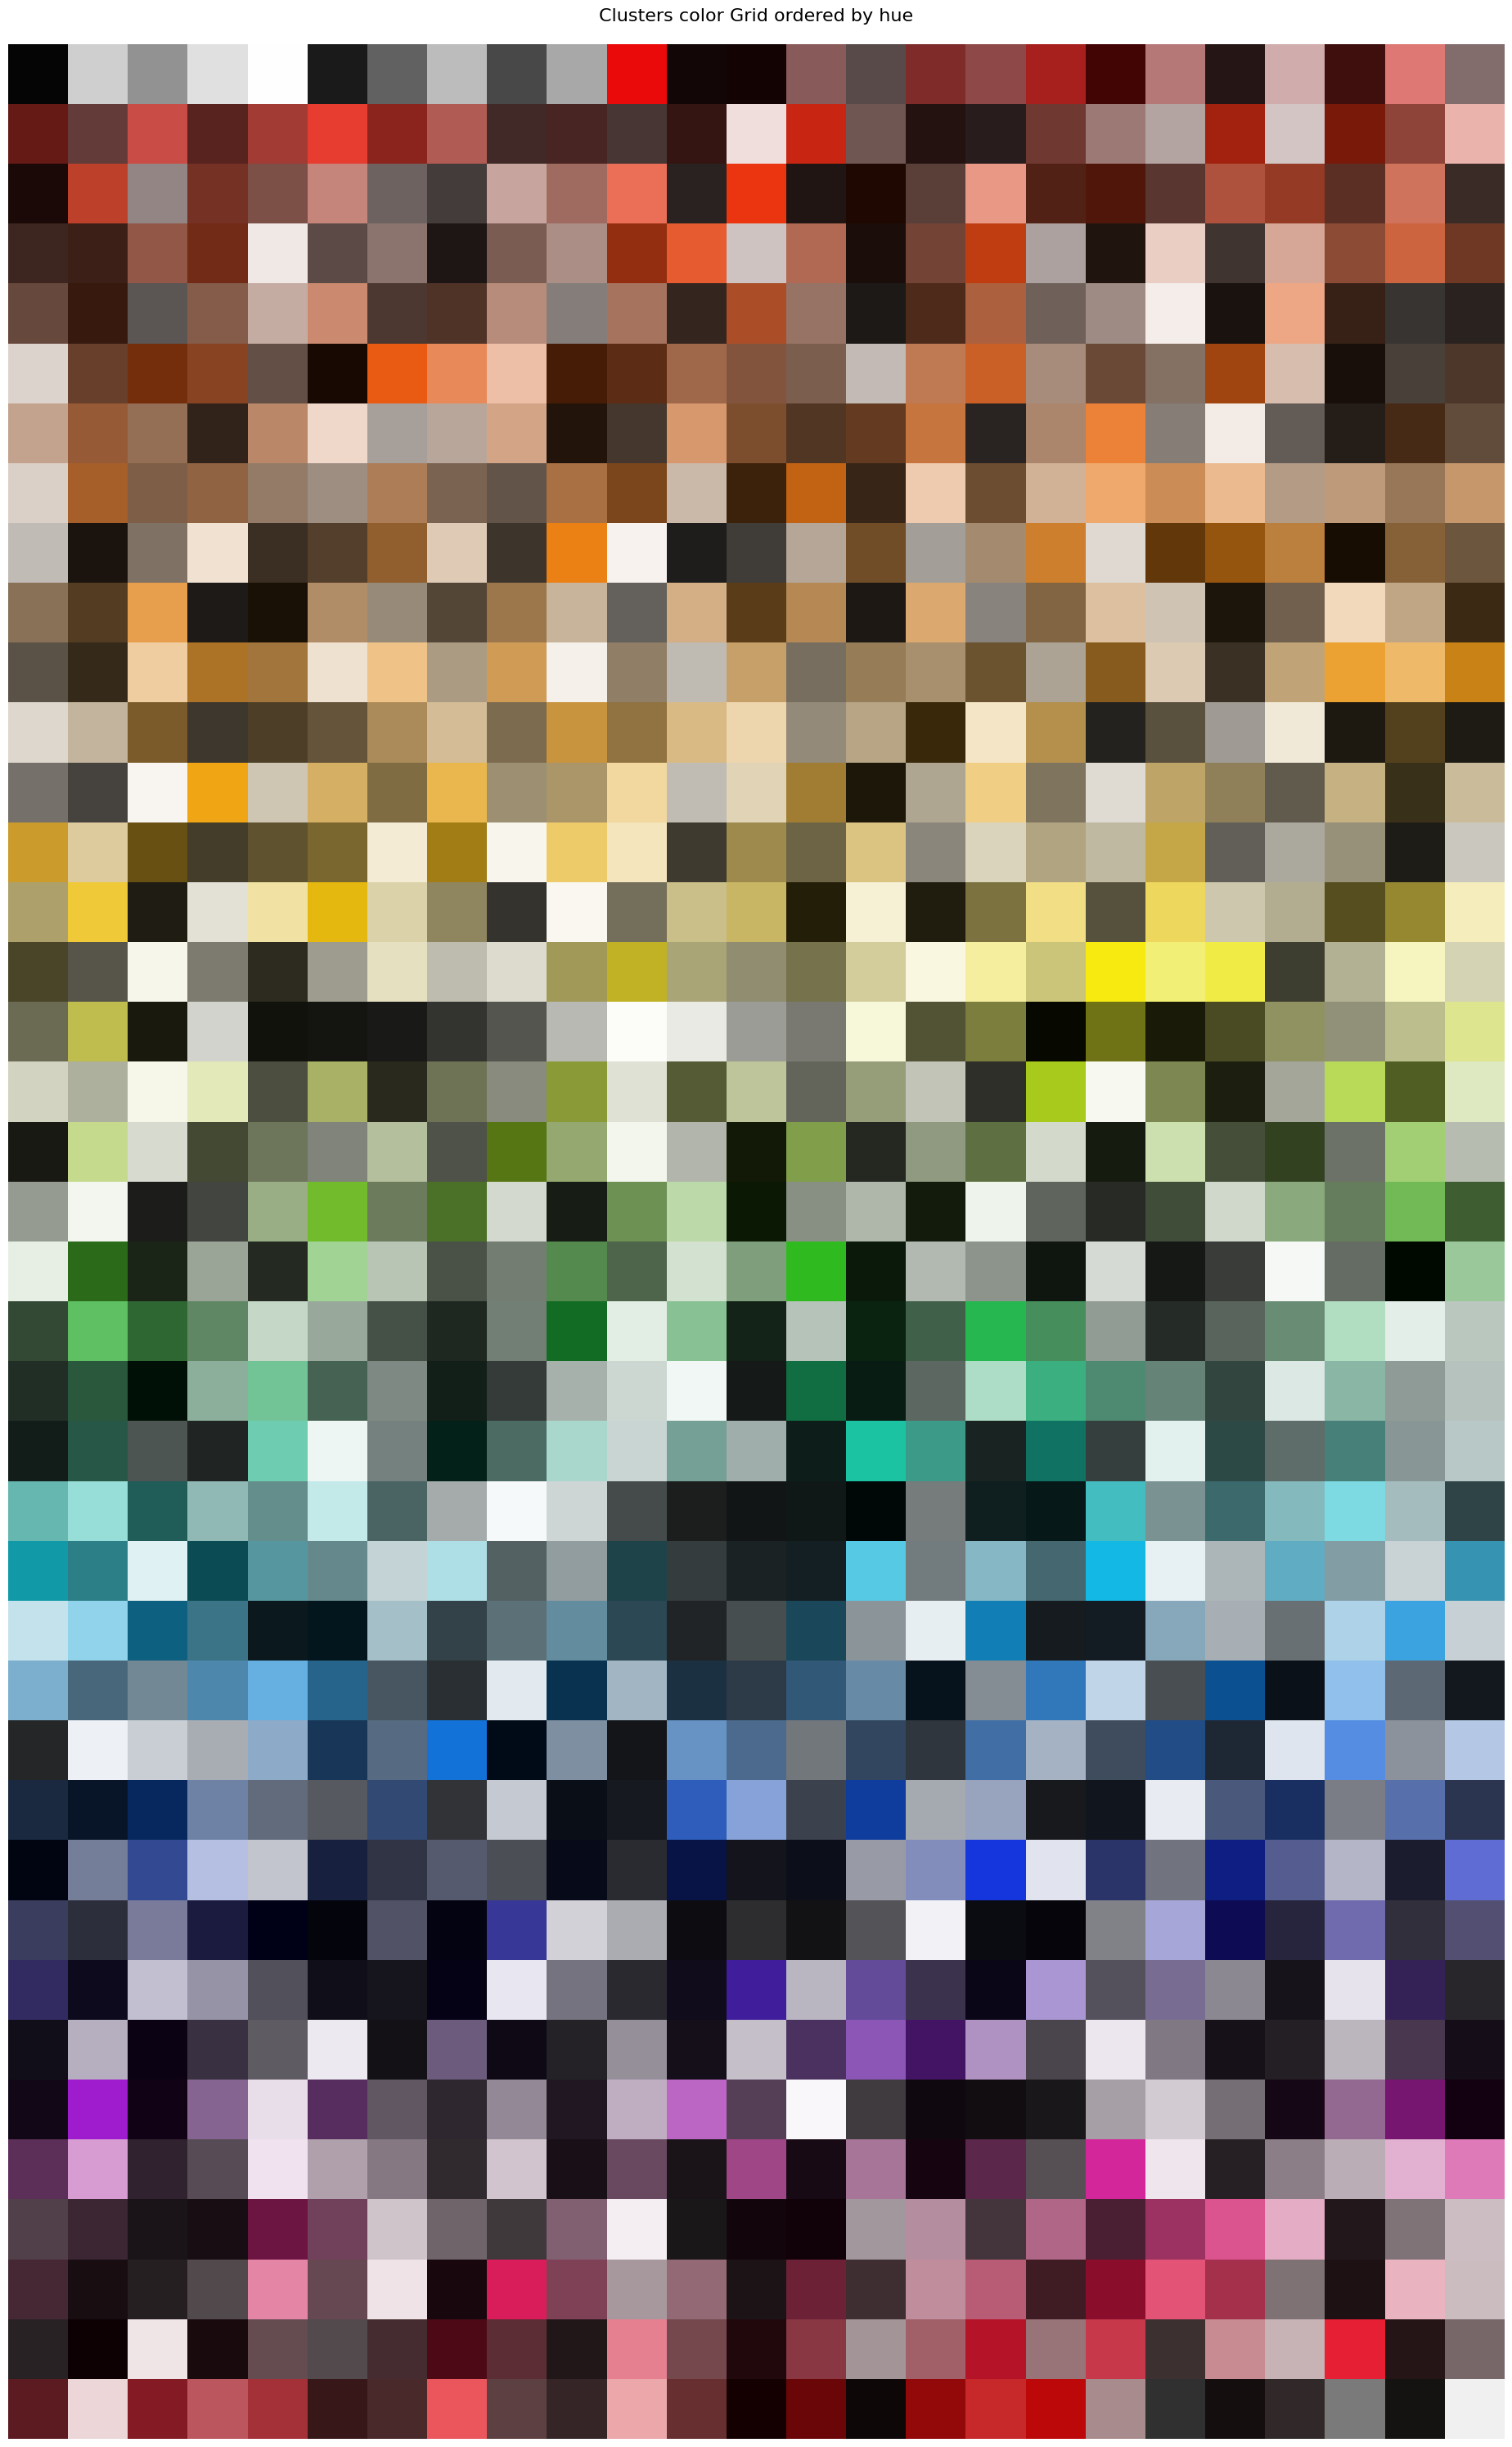

In [ ]:
plot_clusters_color_grid(centroids_df)

**4. Visualization**

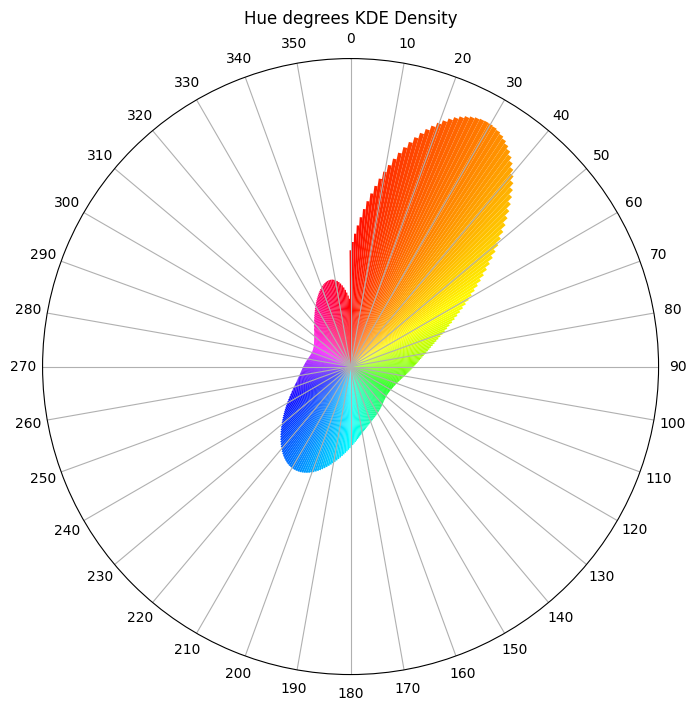

In [ ]:
plot_hues(centroids_df["H_sin"], centroids_df["H_cos"])

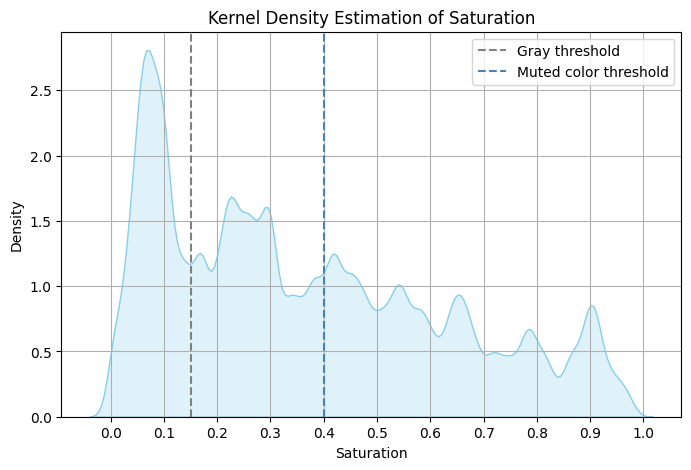

In [ ]:
plot_saturation(centroids_df["S"])

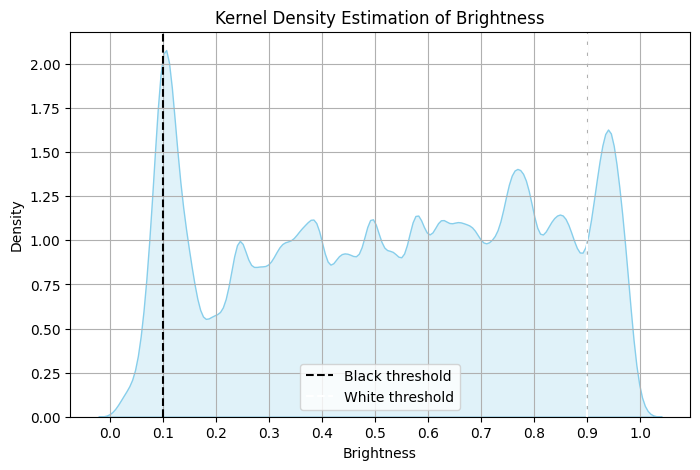

In [ ]:
plot_brightness(centroids_df["B"])

**5. Substitute colors for color clusters**

In [ ]:
new_df = df[["artwork_name", "artist_full_name", "creation_year", "decade", "century", "school", "palette_count", "H", "S", "B"]].copy()

In [ ]:
def assign_clusters(row):        
    h = ast.literal_eval(row["H"])
    s = ast.literal_eval(row["S"])
    b = ast.literal_eval(row["B"])
    h_sin = np.array([utils.hue_to_sin(val) for val in h])
    h_cos = np.array([utils.hue_to_cos(val) for val in h])
    # Create feature array shape (10, 4)
    features = np.stack([h_sin, h_cos, s, b], axis=1)

    # Predict cluster for each color
    return kmeans.predict(features).tolist()

In [ ]:
new_df["cluster_labels"] = df.apply(assign_clusters, axis=1)

In [ ]:
new_df["colors_hex"] = new_df["cluster_labels"].apply(
    lambda label_list: [centroids_df.loc[label, "HEX"] for label in label_list]
)

In [ ]:
new_df = new_df.drop(columns=["H", "S", "B", "cluster_labels"])

In [ ]:
new_df

,artwork_name,artist_full_name,creation_year,decade,century,school,palette_count,colors_hex
0,70 amx,xynphix,2007.0,2000,21.0,modern,"[4009, 7637, 3303, 6147, 4742, 3908, 7216, 514...","[#e2ede4, #969b91, #6eccb0, #2c4945, #addcc7, ..."
1,crucifixion (detail),andrea da firenze,1366.0,1360,14.0,Italy,"[6226, 6056, 4293, 6101, 5185, 5292, 6392, 384...","[#947b67, #7a6351, #82543d, #625449, #3d352c, ..."
2,faith,giuseppe angeli,1754.0,1750,18.0,Italy,"[1007, 4537, 4708, 4466, 4432, 2946, 4776, 448...","[#000707, #9d774c, #965a36, #180f0a, #bcbf8d, ..."
3,lamp post,williamsnape,2010.0,2010,21.0,modern,"[4225, 4308, 4914, 6274, 6911, 6261, 6753, 421...","[#c5aca3, #967365, #4c3830, #402927, #1b3141, ..."
4,the one that got away,katiehofgard,2009.0,2000,21.0,modern,"[43399, 1136, 407, 2637, 2812, 679, 3585, 2514...","[#fefefe, #fefefe, #edf6f3, #987658, #965a36, ..."
...,...,...,...,...,...,...,...,...
264213,truth,circlekeeper,2008.0,2000,21.0,modern,"[1312, 5526, 9605, 9971, 4030, 5524, 5562, 286...","[#9f6b61, #908d71, #3e2e32, #191719, #2b354f, ..."
264214,yavanna queen of the earth giver of fruits-tif...,tiffany-illustration,2017.0,2010,21.0,modern,"[15056, 255, 5087, 6846, 9838, 1577, 4027, 476...","[#fefefe, #f5f9f9, #dfe1d4, #c3b49d, #7a5c53, ..."
264215,unknown,kano furunobu,1700.0,1700,18.0,Japan,"[3431, 5740, 4247, 4971, 6362, 6885, 5328, 445...","[#afa691, #a8906e, #a8906e, #9d8f72, #ab966a, ..."
264216,unknown,wang yuanqi,1715.0,1710,18.0,China,"[6512, 6102, 860, 6846, 4826, 5036, 5117, 3297...","[#f5f0e9, #f7f2ee, #efe1cf, #f2d9bc, #f8f5f0, ..."


In [ ]:
new_df.to_csv("omniart-post-color-clustering.csv", index=False)